# Speed estimation

## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

%matplotlib inline

### Functions

In [2]:
def data_checks(df):
    print(f'Shape: {df.shape}')
    print('Basic info:')
    print(df.info())
    print('Basic statistical description:')
    print(df.describe())

In [3]:
def get_distance(x0, y0, x1, y1):
    xdiff = x1 - x0
    ydiff = y1 - y0
    return sqrt(xdiff*xdiff + ydiff*ydiff)

In [4]:
def get_speed_profile(x_coordinates, y_coordinates):
    assert len(x_coordinates) == len(y_coordinates)
    
    FRAMES_PER_SECOND = 25
    PIXELS_PER_METRE = 14
    ratio = FRAMES_PER_SECOND / PIXELS_PER_METRE
    
    distances = list()
    for i in range(len(x_coordinates) - 1):
        x0, x1 = x_coordinates[i], x_coordinates[i + 1]
        y0, y1 = y_coordinates[i], y_coordinates[i + 1]
        distances.append(get_distance(x0, y0, x1, y1))
    
    speeds = [distance * ratio for distance in distances]
    speeds = [speed for speed in speeds if (speed != 0 and speed < 10)]
    
    total_distance = get_distance(x_coordinates[0], y_coordinates[0],
                                  x_coordinates[-1], y_coordinates[-1])
    average_speed = ratio * total_distance / (len(x_coordinates) - 1)
    
    mean_speed = np.mean(speeds)
    
    return speeds, average_speed, mean_speed

In [5]:
def make_hist(data, xlabel):
    plt.figure()
    plt.hist(data, bins=20, density=True)
    sns.kdeplot(data)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()

### Paths and directories

In [6]:
combined_frames_path = '../outputs/combined_frames.csv'

### Read in data

In [7]:
data = pd.read_csv(combined_frames_path)
data_checks(data)

Shape: (226390, 4)
Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226390 entries, 0 to 226389
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   frame         226390 non-null  int64  
 1   pedestrianID  226390 non-null  int64  
 2   x             226390 non-null  float64
 3   y             226390 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 6.9 MB
None
Basic statistical description:
               frame   pedestrianID              x              y
count  226390.000000  226390.000000  226390.000000  226390.000000
mean     2470.663850     155.137179     392.602947     354.959243
std      1016.745355      74.562383     180.821820     192.724098
min         0.000000       0.000000       0.273183       0.437440
25%      1638.000000     100.000000     241.066288     195.457077
50%      2390.000000     158.000000     403.850970     356.881671
75%      3254.000000     224.000000     535.001

## Analysis

### Create speeds for agents

Our dataset contiains the $x$-$y$ locations for pedestrians in a series of frames.
For each pedestrian, there exist a series of coordinates that collectively form a trajectory which describes the path that he pedestrian takes around the station concourse.
Armed with knowledge regarding the the time interval between frames, we can calculate the speed of individual pedestrians.

For each pedestrian, we have a series of $x$-coordinates and a series of $y$-coordinates:

$$p_i = \{[x_i^0, \ldots, x_i^{n_i}], [y_i^0 \ldots, y_i^{n_i}]\} \quad \forall i \in [0, N]$$

where
* $p_i$: the observations of the $i$th pedestrian
* $x_i^j$: the $i$th pedestrian's $x$-coordinate in the $j$th frame in which the pedestrian appears
* $y_i^j$: the $i$th pedestrian's $x$-coordinate in the $j$th frame in which the pedestrian appears
* $N$: the number of pedestrians in the system
* $n_i$: the number of observations of pedestrian $i$

In [8]:
pedestrian_ids = data['pedestrianID'].unique()
pedestrian_ids = sorted(pedestrian_ids)

In [9]:
pedestrian_trajectories = dict()

for pid in pedestrian_ids:
    tdf = data.loc[data['pedestrianID']==pid, :]
    tdf = tdf.sort_values(by='frame')
    d = {'xs': list(tdf['x']),
         'ys': list(tdf['y'])}
    pedestrian_trajectories[pid] = d

In [10]:
print(len(pedestrian_trajectories))

274


In [11]:
for trajectory in pedestrian_trajectories.values():
    speed, average_speed, mean_speed = get_speed_profile(trajectory['xs'], trajectory['ys'])
    trajectory['speed'] = speed
    trajectory['average_speed'] = average_speed
    trajectory['mean_speed'] = mean_speed

### Average pedestrian speeds

Total distance between pedestrian's initial position and pedestrian's final position:
$$d_i = \sqrt{(x_i^{n_i} - x_i^0)^2 + (y_i^{n_i} - y_i^0)^2}$$

Total time between initial and final observation of $i$th pedestrian in system:
$$t_i = n_i$$

These distances are calculated in pixels and these times are calculated in number of frames. Consequently they need to be rescaled to metres and seconds based on the following information:
* frames per second, $fps = 25$
* pixels per metre , $ppm = 14$

We can then calculate the average speed of the $i$th pedestrian, $\bar{v}_i$:
$$\bar{v}_i = r \times \frac{d_i}{t_i}$$

where $r$ is the rescaling factor:
$$r = \frac{fps}{ppm}$$

Based on this, we can produce a histogram showing the distribution of average speeds for all pedestrians.

In [12]:
# Make list of average speeds, excluding 0s
average_speeds = [d['average_speed'] for d in pedestrian_trajectories.values()]
average_speeds = [s for s in average_speeds if s != 0]

In [13]:
min(average_speeds)

0.31125359137714953

In [14]:
print(f'Mean: {np.mean(average_speeds)}, std: {np.std(average_speeds)}')

Mean: 1.6026400144010877, std: 0.6642343305178546


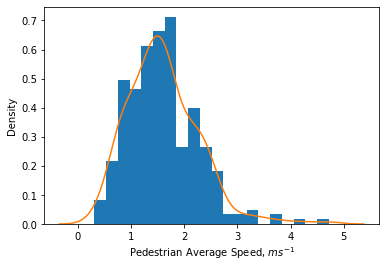

In [15]:
make_hist(average_speeds, 'Pedestrian Average Speed, $m s^{-1}$')

With a mean speed of $1.60$ and a standard deviation of $0.66$ this result is in largely in agreement with average pedestrian speeds observed in the literature [@finnis2006field], particularly when considering speeds observed in similar contexts [@young1999evaluation].
There is, however, an issue with this approach: it measures the distance travelled by the pedestrian as a straight-line between the initial location and final location.
This assumes that each pedestrian travelled in a straight-line for the entirety of their traversal of the station concourse --- this is rather unlikely.
In reality, pedestrians are more likely to have crossed the station from initial location to final location in curve/arc, which would increase the distance travelled by the pedestrian in the time interval for which they are in the observed area.

The following sections attempt to overcome this issue by considering different approaches to finding the average speed of the pedestrians.

### All speeds for all pedestrians

An alternative approach to exploring the speeds of pedestrians is to consider the instantaneous velocity of a pedestrian from one frame to the next.
We can do this by considering the marginal distance travelled between frames; let us consider the distance travelled between the $j$th frame and the $(j+1)$th frame.

Marginal distance between pedestrian's $j$th position and pedestrian's $(j+1)$th position:
$$d_i^j = \sqrt{(x_i^{j+1} - x_i^j)^2 + (y_i^{j+1} - y_i^j)^2}$$

Marginal time between $j$th observation and $(j+1)$th observation of $i$th pedestrian in system:
$$t_i = 1$$

i.e. 1 frame.

Again, these distances and times are calculated in pixels and frames respectively. Consequently they need to be rescaled to metres and seconds based on the following information:
* frames per second, $fps = 25$
* pixels per metre , $ppm = 14$

We can then calculate the instantaneous speed of the $i$th pedestrian in the $j$th observation, $v_i^j$:
$$v_i^j = r \times d_i^j$$

where $r$ is the rescaling factor:
$$r = \frac{fps}{ppm}$$

We can then construct a list of these speeds for each pedestrian:
$$v_i = [v_i^0, \ldots, v_i^{n_i - 1}]$$

Based on this, we can produce a histogram showing the distribution of all instantaneous speeds for all pedestrians.

In [16]:
# Make list of all speeds
all_speeds = list()
for trajectory in pedestrian_trajectories.values():
    all_speeds.extend(trajectory['speed'])

In [17]:
# Filter for feasible human movement speeds
# We shouldn't have anyone moving faster than 10 m/s
all_speeds = [s for s in all_speeds if s < 10]

In [18]:
min(all_speeds)

0.00038978402890117134

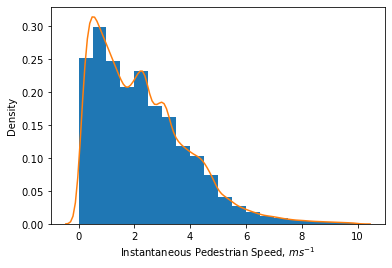

In [19]:
make_hist(all_speeds, 'Instantaneous Pedestrian Speed, $m s^{-1}$')

In [24]:
print(f'Mean: {np.mean(all_speeds)}, Median: {np.median(all_speeds)}')

Mean: 2.2608097153981364, Median: 1.9887305270135667


This shows that whilst a substantial proportion of the speeds are in a sensible range (i.e. $< 2 m s^{-1}$), there is also a substantial proportion of the speeds that are $> 2 m s^{-1}$; this is reflected by the median speed of $1.99 m s^{-1}$.
This may be a result of the dataset that has been used for this analysis - this dataset contains modifications to the original dataset whereby segments of pedestrian trails are joined together in order to form pedestrian trails that as complete as possible, i.e. as many pedestrians as possible have a full trajectory from an entrance gate to an exit gate.
This involves interpolating a pedestrian's path between trail segments, which may require that the pedestrian would have move much faster than typically expected.
This may, therefore, artificially introduce some pedestrian movements that are faster than expected.

### Mean pedestrian speeds

An alternative approach to finding a pedestrian's average speed is to consider the list of speeds produced for each pedestrian in the previous section, and find the mean of that list:
$$\bar{v}_i = \frac{1}{n_i - 1} \sum_{j=0}^{n_i - 1} v_i^j$$

Based on this, we can produce a histogram showing the distribution of average speeds for all pedestrians.

In [20]:
# Make list of average speeds for each pedestrian
mean_speeds = [d['mean_speed'] for d in pedestrian_trajectories.values()]

In [21]:
min(mean_speeds)

0.4461755142533113

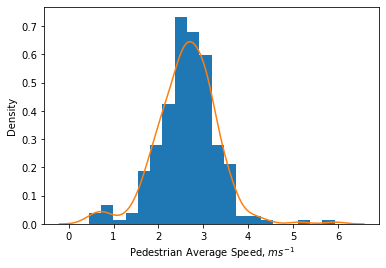

In [22]:
make_hist(mean_speeds, 'Pedestrian Average Speed, $m s^{-1}$')

In [25]:
np.mean(mean_speeds)

2.6293949608344023

As with the previous approach, this shows a distribution of pedestrian walking speeds that are typically faster than would be expected (with a mean of $2.63 m s^{-1}$).
Once again, this may be a result of the trajectory modification/connection process that the data have undergone.
It may, therefore, be worthwhile looking at the original dataset which has not undergone any modifications to join up segments of pedestrian trajectories.